In [15]:
import numpy as np
import math
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

from time import localtime, strftime


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [4]:
this_building = 1176

# {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}
this_meter = 0

data_folder = '../../data/raw/csvs/'
save_folder = '../../data/intermediate/experimentation_train_sets/'

#build_and_save_train(this_building, this_meter, data_folder, save_folder)

In [9]:
# Loads building_metadata to get site-building mapping

data_folder_path = data_folder
bdata = pd.read_csv(data_folder_path + 'building_metadata.csv', 
                    index_col='building_id', usecols=['building_id', 'site_id'])

this_site = bdata.loc[this_building, 'site_id']
print('building is on site {}'.format(this_site))


# Loads meter_reading data
raw_df_meters = pd.read_csv(data_folder_path + 'train.csv', parse_dates=['timestamp'])

to_keep = (raw_df_meters['building_id']==this_building) & (raw_df_meters['meter']==this_meter)
b_df_meters = raw_df_meters[to_keep].copy()

b_df_meters.drop('building_id', axis=1, inplace=True)
b_df_meters.drop('meter', axis=1, inplace=True)

b_df_meters.set_index('timestamp', inplace=True)
b_df_meters.sort_index(inplace=True)

building is on site 13


In [10]:
# Seasonal decomposition.
x_mr = b_df_meters['meter_reading']
mr_decomposition = seasonal_decompose(x_mr.asfreq('1H', method='ffill'), model='multiplicative', two_sided=True)

b_df_meters['meter_reading_seasonal'] = mr_decomposition.seasonal
b_df_meters['meter_reading_trend'] = mr_decomposition.trend
b_df_meters['meter_reading_deseasoned'] = b_df_meters['meter_reading'] - b_df_meters['meter_reading_seasonal']
b_df_meters['meter_reading_resid'] = mr_decomposition.resid


In [26]:
(mr_decomposition.trend * mr_decomposition.seasonal).mean()

113.13951971906464

In [23]:
mr_decomposition.resid.mean()

0.9988314021708362

In [19]:
mr_decomposition.trend.mean()

113.13981448106904

In [30]:
# Compute variable to predict : meter_reading trend
# Two models : additive and multiplicative. We choose additive.
# Two-sided.

rescaled_seasonal = mr_decomposition.trend.mean() * mr_decomposition.seasonal
rebuilt = mr_decomposition.trend * mr_decomposition.seasonal

# seasonal, trend, resid
res_dict = {
    'meter_reading' : x_mr, 
    'rebuilt' : rebuilt,
    'trend' : mr_decomposition.trend, 
    #'seasonal_rsc' : rescaled_seasonal, 
    'residual' : mr_decomposition.resid
}
res_as_df = pd.DataFrame(res_dict)
#res_as_df.head()

In [31]:
df_decomposed_readings = pd.melt(res_as_df.reset_index(inplace=False), id_vars='timestamp', 
                                 var_name='component', value_name = 'reading')
#df_decomposed_readings.head()

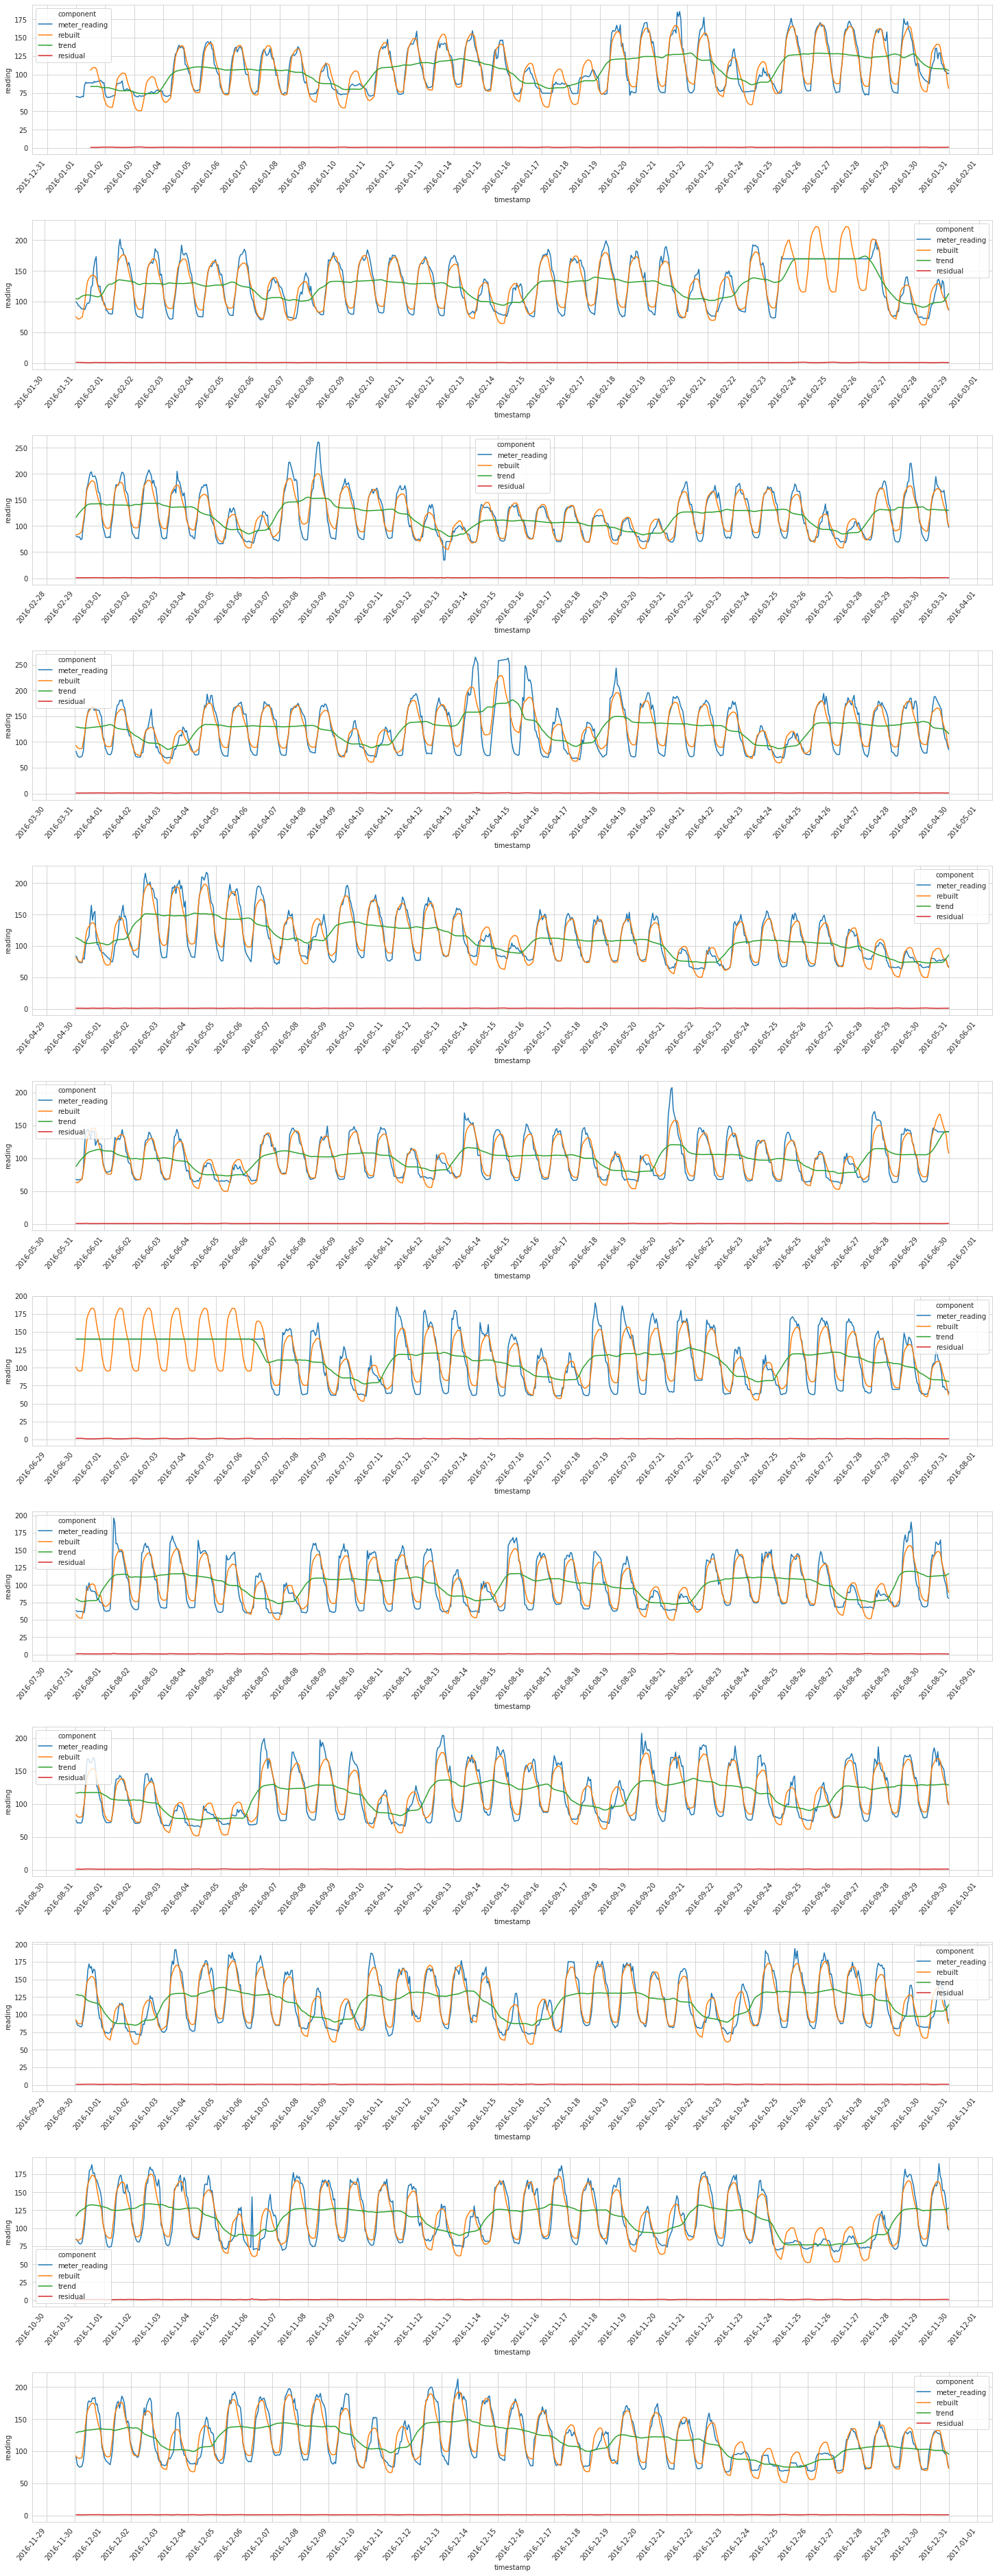

In [32]:
# Plot month by month

date_range = pd.date_range(start=b_df_meters.index.min()-pd.Timedelta('1 days'), 
                           end=b_df_meters.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(df_decomposed_readings, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    

In [7]:
    # Loads building_metadata to get site-building mapping
    bdataa = pd.read_csv(data_folder_path + 'building_metadata.csv', 
                        index_col='building_id', 
                        usecols=['building_id', 'site_id'])

    this_site = bdata.loc[this_building, 'site_id']
    print('building is on site {}'.format(this_site))
    
    
    # Loads meter_reading data
    raw_df_meters = pd.read_csv(data_folder_path + 'train.csv', parse_dates=['timestamp'])

    to_keep = (raw_df_meters['building_id']==this_building) & (raw_df_meters['meter']==this_meter)
    b_df_meters = raw_df_meters[to_keep].copy()

    b_df_meters.drop('building_id', axis=1, inplace=True)
    b_df_meters.drop('meter', axis=1, inplace=True)

    b_df_meters.set_index('timestamp', inplace=True)
    b_df_meters.sort_index(inplace=True)
    
    
    # Seasonal decomposition.
    x_mr = b_df_meters['meter_reading']
    mr_decomposition = seasonal_decompose(x_mr.asfreq('1H', method='ffill'), model='additive', two_sided=True)

    b_df_meters['meter_reading_seasonal'] = mr_decomposition.seasonal
    b_df_meters['meter_reading_trend'] = mr_decomposition.trend
    b_df_meters['meter_reading_deseasoned'] = b_df_meters['meter_reading'] - b_df_meters['meter_reading_seasonal']
    b_df_meters['meter_reading_resid'] = mr_decomposition.resid
    
    
    # Loads weather data
    raw_df_weather = pd.read_csv(data_folder_path + 'weather_train.csv', 
                     parse_dates=['timestamp'], index_col=['site_id','timestamp'])

    b_df_weather = raw_df_weather.loc[(this_site,)]

    b_df_weather.drop('cloud_coverage', axis=1, inplace=True)

    
    # Joins meter_reading and weather dfs.
    df_features = b_df_meters.join(b_df_weather, on='timestamp', how='left')

    
    # Builds time features.
    df_features['day_hour'] = df_features.index.to_series().dt.hour
    df_features['day_of_week'] = df_features.index.to_series().dt.dayofweek
    
    
    # Builds shifted weather features.
    features_to_shift = b_df_weather.columns.to_list()

    shifts = [1, 2, 5, 10]

    for c in features_to_shift:
        ts = df_features[c]
        for shift in shifts:
            shifted_ts = ts.shift(periods=shift, freq='1H')
            new_col_name = '' + c + '_shift_' + str(shift) + 'H'
            df_features[new_col_name] = shifted_ts
            
            
    # Builds averaged weather features.

    timeframes = [4, 24, 72]
    features_to_avg = features_to_shift.copy()
    features_to_avg.remove('wind_direction')
    do_center = False

    for c in features_to_avg:
        ts = df_features[c]
        for timeframe in timeframes:
            shifted_ts = ts.rolling(timeframe, center=do_center).mean()
            new_col_name = '' + c + '_ma_' + str(timeframe) + 'H'
            df_features[new_col_name] = shifted_ts
            
            
    # Drops features with to much NaNs

    #precip_depth_1_hr_ma_72H         297
    #sea_level_pressure_ma_4H         442
    #sea_level_pressure_ma_24H       2014
    #sea_level_pressure_ma_72H       4590

    #wind_direction_shift_1H          221
    #wind_direction_shift_2H          223
    #wind_direction_shift_5H          229
    #wind_direction_shift_10H         235

    #air_temperature_ma_72H           215
    #dew_temperature_ma_72H           215

    to_drop=[
        'precip_depth_1_hr_ma_72H', 
        'sea_level_pressure_ma_4H' ,
        'sea_level_pressure_ma_24H',
        'sea_level_pressure_ma_72H',
        'wind_direction_shift_1H',
        'wind_direction_shift_2H',
        'wind_direction_shift_5H',
        'wind_direction_shift_10H',
        'air_temperature_ma_72H',
        'dew_temperature_ma_72H'
    ]

    df_features.drop(to_drop, axis=1, inplace=True)
    df_features.isna().sum()
    
    
    # Keeps only a selected subset of the generated features. (for instance based on eda).
    selected_features = [
        'day_of_week',
        'day_hour',
        'dew_temperature_ma_24H',
        'air_temperature',
        'wind_speed_ma_24H', 
        'precip_depth_1_hr_ma_24H',
        'sea_level_pressure_shift_10H'
    ]
    
    selected_targets = ['meter_reading', 'meter_reading_trend', 
                        'meter_reading_seasonal','meter_reading_deseasoned', 'meter_reading_resid']
    
    print('selected_features = {}'.format(selected_features))
    
    df_selected_features = df_features[selected_features+selected_targets].copy()

    
    # Drops rows with NaNs.
    df_selected_features.dropna(axis=0, how='any', inplace=True)
    
    
    # Saves as csv.
    time_str = strftime('%Y%m%d_%H%M%S', localtime())
    filename = 'train_b_' + str(this_building) + '_m_' + str(this_meter) + '_t_' + time_str + '.csv'
    filepath = save_folder_path + filename
    
    df_selected_features.to_csv(filepath)
    print('saved as {}'.format(filepath))


Let's try to find the better transformation for seasonal decomposition by plotting spread vs level.<br>
https://stats.stackexchange.com/questions/74537/log-or-square-root-transformation-for-arima

In [38]:
meter_data = b_df_meters[['meter_reading']].copy()
meter_data['day_of_year'] = meter_data.index.to_series().dt.dayofyear

In [98]:
grouped = meter_data.groupby('day_of_year').quantile(q=.25).rename({'meter_reading' : 'first_quartile'}, axis=1)
grouped['median'] = meter_data.groupby('day_of_year').quantile(q=.5)
grouped['third_quartile'] = meter_data.groupby('day_of_year').quantile(q=.75)
grouped['spread'] = grouped['third_quartile'] - grouped['first_quartile']

In [99]:
grouped.head(5)

,first_quartile,median,third_quartile,spread
day_of_year,,,,
1,70.37625,88.5830,89.69650,19.32025
2,70.99525,77.5450,81.69550,10.70025
3,70.98925,74.4835,76.74050,5.75125
4,72.31800,106.2040,130.87275,58.55475
5,82.78525,107.6925,135.57800,52.79275


In [100]:
# Get rid of spreads == 0 
# (which are days where there was only missing values that were interpolated with a constant value)

print('n_spread_equals_0_before = {}'.format((grouped[['spread']] == 0).sum()[0]))
rows_to_drop = grouped[grouped['spread'] == 0].index
grouped.drop(rows_to_drop, axis=0, inplace=True)
print('n_spread_equals_0_after = {}'.format((grouped[['spread']] == 0).sum()[0]))

n_spread_equals_0_before = 8
n_spread_equals_0_after = 0


In [105]:
log_spread = np.log(grouped['spread'])
log_median = np.log(grouped['median'])
spread_vs_level_data = pd.DataFrame({'log_spread' : log_spread, 'log_median':log_median})

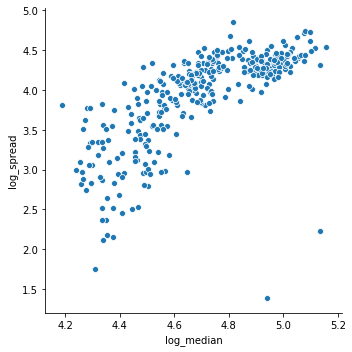

In [107]:
sns.relplot(x="log_median", y="log_spread", data=spread_vs_level_data);

In [ ]:
# TODO remove the two outliers

In [109]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(log_median,log_spread)

In [112]:
print('slope = {}'.format(slope))
print('power lambda = 1 - slope = {}'.format(1-slope))

slope = 1.8177008707320814
power lambda = 1 - slope = -0.8177008707320814
